파이토치에서는 임베딩 벡터를 사용하는 방법이 크게 두 가지가 있습니다. 바로 임베딩 층(embedding layer)을 만들어 훈련 데이터로부터 처음부터 임베딩 벡터를 학습하는 방법과 미리 사전에 훈련된 임베딩 벡터(pre-trained word embedding)들을 가져와 사용하는 방법입니다. 이번 챕터에서는 전자에 해당되는 방법에 대해서 배웁니다. 파이토치에서는 이를 nn.Embedding()를 사용하여 구현합니다.

이와 대조되는 방법인 사전에 훈련된 임베딩 벡터(pre-trained word embedding)를 사용하는 방법은 다음 챕터에서 다룹니다.

### 1. 임베딩 층은 룩업 테이블이다.
임베딩 층의 입력으로 사용하기 위해서 입력 시퀀스의 각 단어들은 모두 정수 인코딩이 되어있어야 합니다.

어떤 단어 → 단어에 부여된 고유한 정수값 → 임베딩 층 통과 → 밀집 벡터

임베딩 층은 입력 정수에 대해 밀집 벡터(dense vector)로 맵핑하고 이 밀집 벡터는 인공 신경망의 학습 과정에서 가중치가 학습되는 것과 같은 방식으로 훈련됩니다. 훈련 과정에서 단어는 모델이 풀고자하는 작업에 맞는 값으로 업데이트 됩니다. 그리고 이 밀집 벡터를 임베딩 벡터라고 부릅니다.

정수를 밀집 벡터 또는 임베딩 벡터로 맵핑한다는 것은 어떤 의미일까요? 특정 단어와 맵핑되는 정수를 인덱스로 가지는 테이블로부터 임베딩 벡터 값을 가져오는 룩업 테이블이라고 볼 수 있습니다. 그리고 이 테이블은 단어 집합의 크기만큼의 행을 가지므로 모든 단어는 고유한 임베딩 벡터를 가집니다.


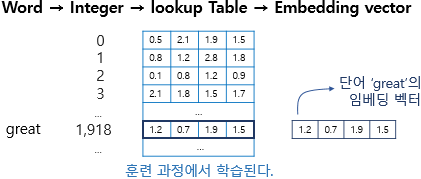


위의 그림은 단어 great이 정수 인코딩 된 후 테이블로부터 해당 인덱스에 위치한 임베딩 벡터를 꺼내오는 모습을 보여줍니다. 위의 그림에서는 임베딩 벡터의 차원이 4로 설정되어져 있습니다. 그리고 단어 great은 정수 인코딩 과정에서 1,918의 정수로 인코딩이 되었고 그에 따라 단어 집합의 크기만큼의 행을 가지는 테이블에서 인덱스 1,918번에 위치한 행을 단어 great의 임베딩 벡터로 사용합니다. 이 임베딩 벡터는 모델의 입력이 되고, 역전파 과정에서 단어 great의 임베딩 벡터값이 학습됩니다.

룩업 테이블의 개념을 이론적으로 우선 접하고, 처음 파이토치를 배울 때 어떤 분들은 임베딩 층의 입력이 원-핫 벡터가 아니어도 동작한다는 점에 헷갈려 합니다. 파이토치는 단어를 정수 인덱스로 바꾸고 원-핫 벡터로 한번 더 바꾸고나서 임베딩 층의 입력으로 사용하는 것이 아니라, 단어를 정수 인덱스로만 바꾼채로 임베딩 층의 입력으로 사용해도 룩업 테이블 된 결과인 임베딩 벡터를 리턴합니다.

룩업 테이블 과정을 nn.Embedding()을 사용하지 않고 구현해보면서 이해해보겠습니다.
우선 임의의 문장으로부터 단어 집합을 만들고 각 단어에 정수를 부여합니다.

In [2]:
import torch

In [1]:
train_data = 'you need to know how to code'

# 중복을 제거한 단어들의 집합인 단어 집합 생성.
word_set = set(train_data.split())

# 단어 집합의 각 단어에 고유한 정수 맵핑.
vocab = {word: i+2 for i, word in enumerate(word_set)}
vocab['<unk>'] = 0
vocab['<pad>'] = 1
print(vocab)

{'you': 2, 'how': 3, 'code': 4, 'need': 5, 'to': 6, 'know': 7, '<unk>': 0, '<pad>': 1}


In [3]:
# 이제 단어 집합의 크기를 행으로 가지는 임베딩 테이블을 구현합니다. 단, 여기서 임베딩 벡터의 차원은 3으로 정했습니다.

# 단어 집합의 크기만큼의 행을 가지는 테이블 생성.
embedding_table = torch.FloatTensor([
                               [ 0.0,  0.0,  0.0],
                               [ 0.0,  0.0,  0.0],
                               [ 0.2,  0.9,  0.3],
                               [ 0.1,  0.5,  0.7],
                               [ 0.2,  0.1,  0.8],
                               [ 0.4,  0.1,  0.1],
                               [ 0.1,  0.8,  0.9],
                               [ 0.6,  0.1,  0.1]])

이제 임의의 문장 'you need to run'에 대해서 룩업 테이블을 통해 임베딩 벡터들을 가져와보겠습니다.

In [4]:
sample = 'you need to run'.split()
idxes = []

# 각 단어를 정수로 변환
for word in sample:
  try:
    idxes.append(vocab[word])
  # 단어 집합에 없는 단어일 경우 <unk>로 대체된다.
  except KeyError:
    idxes.append(vocab['<unk>'])
idxes = torch.LongTensor(idxes)

# 각 정수를 인덱스로 임베딩 테이블에서 값을 가져온다.
lookup_result = embedding_table[idxes, :]
print(lookup_result)

tensor([[0.2000, 0.9000, 0.3000],
        [0.4000, 0.1000, 0.1000],
        [0.1000, 0.8000, 0.9000],
        [0.0000, 0.0000, 0.0000]])


### 2. 임베딩 층 사용하기
이제 nn.Embedding()으로 사용할 경우를 봅시다. 우선 전처리는 동일한 과정을 거칩니다.

In [5]:
train_data = 'you need to know how to code'

# 중복을 제거한 단어들의 집합인 단어 집합 생성.
word_set = set(train_data.split())

# 단어 집합의 각 단어에 고유한 정수 맵핑.
vocab = {tkn: i+2 for i, tkn in enumerate(word_set)}
vocab['<unk>'] = 0
vocab['<pad>'] = 1

In [6]:
# 이제 nn.Embedding()을 사용하여 학습가능한 임베딩 테이블을 만듭니다.
import torch.nn as nn
embedding_layer = nn.Embedding(num_embeddings=len(vocab), 
                               embedding_dim=3,
                               padding_idx=1)

nn.Embedding은 크게 두 가지 인자를 받는데 각각 num_embeddings과 embedding_dim입니다.

- num_embeddings : 임베딩을 할 단어들의 개수. 다시 말해 단어 집합의 크기입니다.
- embedding_dim : 임베딩 할 벡터의 차원입니다. 사용자가 정해주는 하이퍼파라미터입니다.
- padding_idx : 선택적으로 사용하는 인자입니다. 패딩을 위한 토큰의 인덱스를 알려줍니다.

In [7]:
print(embedding_layer.weight)

Parameter containing:
tensor([[-0.3140, -1.2875, -0.1029],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.4472, -0.5031,  0.0703],
        [-0.4018, -1.6296,  1.1933],
        [ 0.7817, -0.6378,  3.5005],
        [-0.1371,  0.0958, -0.8662],
        [ 1.6524, -0.0665, -0.0457],
        [-0.9967, -1.6511, -0.4013]], requires_grad=True)
